In [1]:
import pandas as pd
from tqdm.auto import tqdm
import os 
import json
import numpy as np
from scipy.stats import ttest_ind
from collections import defaultdict

In [6]:
# plot the data
import seaborn as sns
import scienceplots
import matplotlib.pyplot as plt

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 6,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.style.use(['science', 'nature'])
plt.rcParams.update(tex_fonts)

import matplotlib.font_manager

fm = matplotlib.font_manager.json_load("/home/chensun/.cache/matplotlib/fontlist-v330.json")

fm.findfont("serif", rebuild_if_missing=False)

'/home/data/chensun/affi_project/yes/envs/openwpm/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf'

# Calculate average accuracy scores

In [8]:
# calculate different in each iteration
RESULT_DIR = "../../output/results/aff_ads_graph_level_fullGraph"


In [12]:
iteration = 100
accuracy_results = {}
precision_results = {}
recall_results = {}

for i in range(iteration):
    unseen_accuracy_path = f"/home/data/chensun/affi_project/purl/output/results/02_28_uniform_Kfold_CV_AFF_OTHERS_allF/phase1/{i}/with_model"
    testing_accuracy_path = f"/home/data/chensun/affi_project/purl/output/results/02_28_uniform_Kfold_CV_AFF_OTHERS_allF/phase1/{i}"

    accuracy_dict = {}
    precision_dict = {}
    recall_dict = {}

    # Parse accuracy from testing accuracy file
    with open(os.path.join(testing_accuracy_path, "accuracy")) as f:
        lines = f.readlines()
        for line in lines:
            if "Accuracy" in line:
                accuracy_str = line.split(":")[1].strip().replace("%", "")
                accuracy = float(accuracy_str)
                accuracy_dict["Testing_Accuracy"] = accuracy
            elif "Precision" in line and 'binary' in line:
                precision_str = line.split(":")[1].split(' ')[2].strip().replace("%", "")
                precision = float(precision_str)
                precision_dict["Testing_Precision"] = precision

            elif "Recall" in line and 'binary' in line:
                recall_str = line.split(":")[1].split(' ')[2].strip().replace("%", "")
                recall = float(recall_str)
                recall_dict["Testing_Recall"] = recall

    # Parse accuracy from unseen accuracy file
    with open(os.path.join(unseen_accuracy_path, "classification_metrics.txt")) as f:
        lines = f.readlines()
        for line in lines:
            if "Accuracy" in line:
                accuracy_str = line.split(":")[1].strip().replace("%", "")
                accuracy = float(accuracy_str) * 100.0  # Convert percentage to fraction
                accuracy_dict["Unseen_Accuracy"] = accuracy
            elif "Precision" in line:
                precision = line.split(":")[1].strip().replace("%", "")
                precision = float(precision) * 100.0
                precision_dict["Unseen_Percision"] = precision
            elif "Recall" in line:
                recall = line.split(":")[1].strip().replace("%", "")
                recall = float(recall) * 100.0
                recall_dict["Unseen_Recall"] = recall

    accuracy_results[i] = accuracy_dict
    precision_results[i] = precision_dict
    recall_results[i] = recall_dict

# Now accuracy_results is a dictionary where each key is an iteration number
# and the corresponding value is a dictionary containing testing and unseen accuracy
print(accuracy_results)
print(precision_results)
print(recall_results)

{0: {'Testing_Accuracy': 97.535, 'Unseen_Accuracy': 92.0}, 1: {'Testing_Accuracy': 97.66, 'Unseen_Accuracy': 93.02325581395348}, 2: {'Testing_Accuracy': 97.849, 'Unseen_Accuracy': 95.74468085106383}, 3: {'Testing_Accuracy': 97.546, 'Unseen_Accuracy': 97.36842105263158}, 4: {'Testing_Accuracy': 97.713, 'Unseen_Accuracy': 100.0}, 5: {'Testing_Accuracy': 96.467, 'Unseen_Accuracy': 98.0392156862745}, 6: {'Testing_Accuracy': 97.71, 'Unseen_Accuracy': 92.0}, 7: {'Testing_Accuracy': 97.863, 'Unseen_Accuracy': 76.0}, 8: {'Testing_Accuracy': 98.14, 'Unseen_Accuracy': 100.0}, 9: {'Testing_Accuracy': 97.531, 'Unseen_Accuracy': 98.27586206896551}, 10: {'Testing_Accuracy': 98.018, 'Unseen_Accuracy': 95.23809523809523}, 11: {'Testing_Accuracy': 97.71, 'Unseen_Accuracy': 95.0}, 12: {'Testing_Accuracy': 97.706, 'Unseen_Accuracy': 94.73684210526315}, 13: {'Testing_Accuracy': 98.009, 'Unseen_Accuracy': 89.28571428571429}, 14: {'Testing_Accuracy': 96.804, 'Unseen_Accuracy': 100.0}, 15: {'Testing_Accuracy

In [13]:
# Extract unseen accuracy values from accuracy_results dictionary
iteration = 100
unseen_accuracies = [accuracy_results[i]['Unseen_Accuracy'] for i in range(iteration)]
mean_unseen_accuracy = sum(unseen_accuracies) / len(unseen_accuracies)

unseen_percision = [precision_results[i]['Unseen_Percision'] for i in range(iteration)]
mean_unseen_percision = sum(unseen_percision) / len(unseen_percision)

unseen_recall = [recall_results[i]['Unseen_Recall'] for i in range(iteration)]
mean_unseen_recall = sum(unseen_recall) / len(unseen_recall)

print("Mean Unseen Accuracy:", mean_unseen_accuracy)
print("Mean Unseen Percision:", mean_unseen_percision)
print("Mean Unseen Recall:", mean_unseen_recall)


Mean Unseen Accuracy: 94.63597042436373
Mean Unseen Percision: 98.02862072316759
Mean Unseen Recall: 91.69011428161936


In [14]:
# Extract testing accuracy values from accuracy_results dictionary
iteration = 100
testing_Accuracy = [accuracy_results[i]['Testing_Accuracy'] for i in range(iteration)]
mean_testing_Accuracy = sum(testing_Accuracy) / len(testing_Accuracy)

testing_percision = [precision_results[i]['Testing_Precision'] for i in range(iteration)]
mean_testing_percision = sum(testing_percision) / len(testing_percision)

testing_recall = [recall_results[i]['Testing_Recall'] for i in range(iteration)]
mean_testing_recall = sum(testing_recall) / len(testing_recall)

print("Mean Testing Accuracy:", mean_testing_Accuracy)
print("Mean Testing Percison:", mean_testing_percision)
print("Mean Testing Recall:", mean_testing_recall)

Mean Testing Accuracy: 97.5969299999999
Mean Testing Percison: 96.45817999999997
Mean Testing Recall: 97.55781999999998


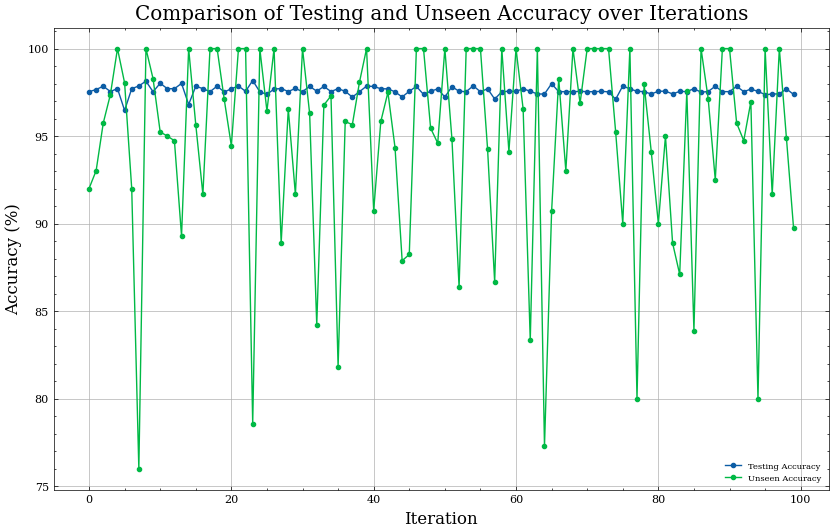

In [15]:
# comparison between Testing Accuracy and Unseen Accuracy for each iteration
iterations = list(accuracy_results.keys())
testing_accuracy = [accuracy_results[i]['Testing_Accuracy'] for i in iterations]
unseen_accuracy = [accuracy_results[i]['Unseen_Accuracy'] for i in iterations]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(iterations, testing_accuracy, label='Testing Accuracy', marker='o')
plt.plot(iterations, unseen_accuracy, label='Unseen Accuracy', marker='o')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Testing and Unseen Accuracy over Iterations')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

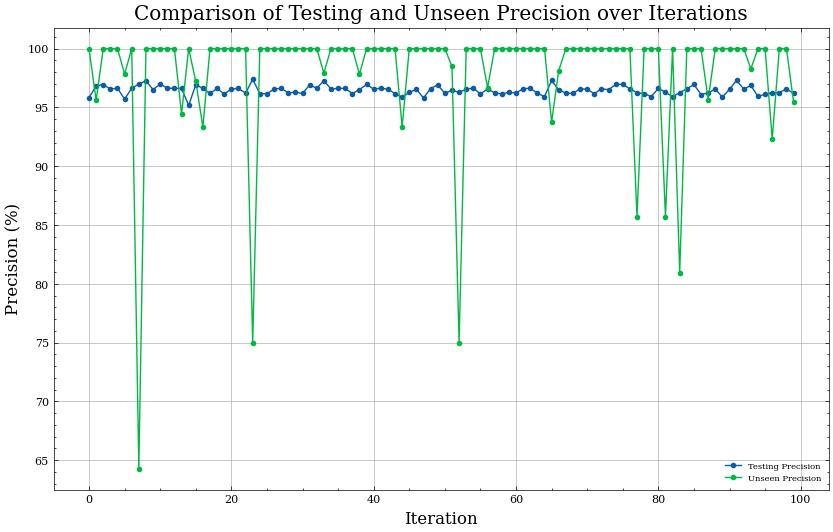

In [16]:
# comparison between Testing Precision and Unseen Precision for each iteration
iterations = list(precision_results.keys())
testing_percision = [precision_results[i]['Testing_Precision'] for i in iterations]
unseen_percision = [precision_results[i]['Unseen_Percision'] for i in iterations]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(iterations, testing_percision, label='Testing Precision', marker='o')
plt.plot(iterations, unseen_percision, label='Unseen Precision', marker='o')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Precision (%)')
plt.title('Comparison of Testing and Unseen Precision over Iterations')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

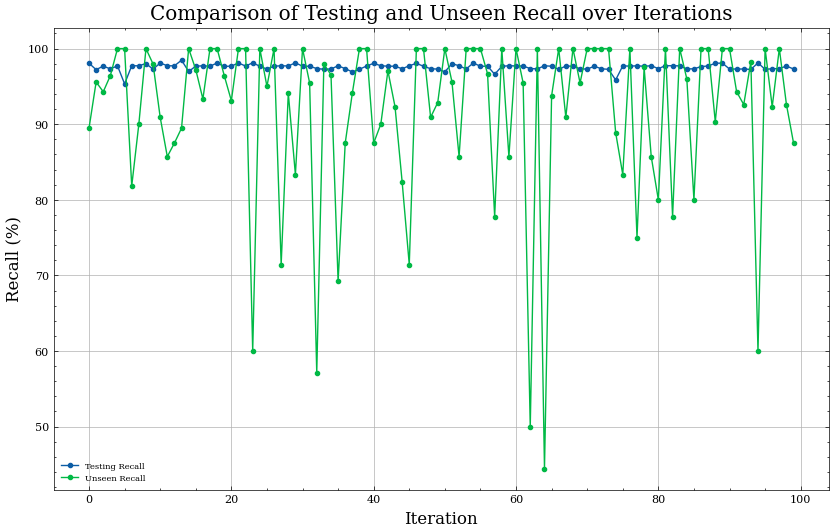

In [17]:
# comparison between Testing Precision and Unseen Precision for each iteration
iterations = list(recall_results.keys())
testing_recall = [recall_results[i]['Testing_Recall'] for i in iterations]
unseen_recall = [recall_results[i]['Unseen_Recall'] for i in iterations]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(iterations, testing_recall, label='Testing Recall', marker='o')
plt.plot(iterations, unseen_recall, label='Unseen Recall', marker='o')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Recall (%)')
plt.title('Comparison of Testing and Unseen Recall over Iterations')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

Get the important features from each round of iteration

In [20]:
feature_importance_directory = "/home/data/chensun/affi_project/purl/output/results/02_28_uniform_Kfold_CV_AFF_OTHERS_allF/phase1"

# Initialize a dictionary to store cumulative importance for each feature
cumulative_importance = defaultdict(float)

# Loop over each iteration
iteration = 100
for i in range(iteration):
    # Load the feature importance file for this iteration
    importance_file_path = os.path.join(feature_importance_directory, str(i), "featimp")
    
    # Read the file and extract the importance values
    with open(importance_file_path) as f:
        # Skip the header line
        next(f)
        # Read the remaining lines
        for line in f:
            # Split the line into feature and importance value
            feature, importance = line.strip().split()
            # Convert importance to float
            importance = float(importance)
            # Add the importance to the cumulative importance for this feature
            cumulative_importance[feature] += importance

# Sort the features based on cumulative importance
sorted_features = sorted(cumulative_importance.items(), key=lambda x: x[1], reverse=True)

# Extract the top 10 important features
top_10_features = sorted_features[:30]

# Print the top 10 important features
print("Top 30 Important Features:")
for feature, importance in top_10_features:
    print(f"{feature}: {importance}")

Top 30 Important Features:
landing_url_shannon_entropy: 16.072413499999996
landing_url_num_query_params: 15.106339700000003
max_avg_path_length: 9.959394399999999
average_shannon_entropy: 9.429548699999996
average_path_length_for_largest_cc: 8.203271019999997
max_degree_centrality: 7.008638470000001
init_url_shannon_entropy: 5.240936670000001
init_url_num_query_params: 5.031391810000001
std_dev_degree_centrality: 4.862744709999999
num_of_redirect: 4.24408704
std_dev_closeness_centrality_outward: 2.1816179
max_closeness_centrality_outward: 1.8909093690000007
min_degree_centrality: 1.0479132
num_nodes: 1.0032813130000002
num_edges: 0.865869805
average_size_cc: 0.7395275519999999
median_degree_centrality: 0.737193966
density: 0.592726246
average_degree_centrality: 0.5714889600000002
largest_cc: 0.443948057
average_closeness_centrality: 0.4302126290000001
std_dev_closeness_centrality: 0.3839372800000002
average_closeness_centrality_outward: 0.34711746599999993
max_closeness_centrality: 0.3

In [18]:
unseen_iteration = "/home/data/chensun/affi_project/purl/output/results/02_21_uniform_Kfold_CV/phase1/57/with_model/labelled_results.csv"
df = pd.read_csv(unseen_iteration)

In [22]:
# Filter the DataFrame where url_domain is equal to x
filtered_df = df[df['url_domain'] == "revcontent.com"]

# Count the number of matches between ctrue and true columns
num_matches = (filtered_df['clabel'] == filtered_df['label']).sum()
print(num_matches)

5


In [17]:
RESULT_DIR = "../../output/results/aff_ads_graph_level_fullGraph"

with open(os.path.join(RESULT_DIR, "accuracy")) as f:
    lines = f.readlines()
    print(lines)

    total_accuracy = 0
    total_precision = 0
    total_recall = 0
    count = 0
    for line in lines:
        accuracy = 0
        precision = 0
        recall = 0
        if "Accuracy" in line:
            accuracy = line.split(":")[1].strip()
        elif "Precision" in line and 'binary' in line:
            precision = line.split(":")[1].split(' ')[2].strip()
        elif "Recall" in line and 'binary' in line:
            recall = line.split(":")[1].split(' ')[2].strip()
        
        


FileNotFoundError: [Errno 2] No such file or directory: '../../output/results/aff_ads_graph_level_fullGraph/accuracy'

In [41]:
df_labeled = pd.read_csv('/home/data/chensun/affi_project/purl/output/results/02_21_uniform_Kfold_CV/phase1/55/result.csv')
#df_labeled = pd.read_csv('/home/data/chensun/affi_project/purl/output/results/02_14_LeaveOneGroupOut/phase1/result.csv')

In [42]:
# Separate data into two groups based on the label
ads_data = df_labeled[df_labeled['label'] == 'ads']['max_out_degree']
affiliate_data = df_labeled[df_labeled['label'] == 'affiliate']['max_out_degree']

# Perform T-test
t_statistic, p_value = ttest_ind(ads_data, affiliate_data)

# Interpret results
alpha = 0.05  # significance level
if p_value < alpha:
    print("The difference in means is statistically significant.")
else:
    print("The difference in means is not statistically significant.")

The difference in means is statistically significant.


In [49]:
df = pd.read_csv('/home/data/chensun/affi_project/purl/output/results/02_21_uniform_Kfold_CV/phase1/55/with_model/labelled_results.csv')
filtered_df = df[df['url_domain'] == 'amazon.com']
same_data = filtered_df[filtered_df['label'] == filtered_df['clabel']]
print(len(same_data))
different_data = filtered_df[filtered_df['label'] != filtered_df['clabel']]
print(len(different_data))

24
3


In [54]:
same_data[same_data.label == 'affiliate'].average_closeness_centrality_outward .describe()

count    24.000000
mean      0.067688
std       0.009591
min       0.045455
25%       0.062500
50%       0.066667
75%       0.071429
max       0.100000
Name: average_closeness_centrality_outward, dtype: float64

In [55]:
different_data[different_data.label == 'affiliate'].average_closeness_centrality_outward .describe()

count    3.000000
mean     0.076923
std      0.000000
min      0.076923
25%      0.076923
50%      0.076923
75%      0.076923
max      0.076923
Name: average_closeness_centrality_outward, dtype: float64

In [26]:
# plt.figure(figsize=(8, 6))
count, bins_negative = np.histogram(df_labeled[df_labeled.max_out_degree < 1.25][df_labeled.label == 'affiliate'].max_out_degree, 24)
pdf_negative = count / sum(count)
cdf_negative = np.cumsum(pdf_negative)
plt.plot(bins_negative[1:], cdf_negative, label="affiliate", color='green')

count, bins_positive = np.histogram(df_labeled[df_labeled.max_out_degree < 1.25][df_labeled.label == 'ads'].max_out_degree, 24)
pdf_positive = count / sum(count)
cdf_positive = np.cumsum(pdf_positive)
plt.plot(bins_positive[1:], cdf_positive, label="ads", color='red')
plt.legend()
plt.xlabel("num_all_gets_in_product_node")
plt.ylabel("CDF")
plt.savefig("/home/data/chensun/affi_project/purl/output/results/aff_ads_mean_phaseA/nodes_div_by_edges.pdf", dpi=300, bbox_inches='tight')

AttributeError: 'DataFrame' object has no attribute 'num_all_gets_in_product_node'

In [32]:
df_labeled[df_labeled.label == 'ads'].max_out_degree.describe()

count    191.000000
mean      22.146597
std       20.338697
min        4.000000
25%       12.000000
50%       17.000000
75%       27.000000
max      188.000000
Name: max_out_degree, dtype: float64

In [23]:
# Analysis unseen data
df_unseen_labeled = pd.read_csv('/home/data/chensun/affi_project/purl/output/results/02_21_LeaveOneGroupOut/phase1/57/with_model/labelled_results.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/home/data/chensun/affi_project/purl/output/results/02_21_LeaveOneGroupOut/phase1/57/with_model/labelled_results.csv'

In [68]:
domain_url_counts = df_unseen_labeled.groupby('url_domain')['top_level_url'].nunique()
domain_url_counts_dict = domain_url_counts.to_dict()
sorted_domain_url_counts_dict = dict(sorted(domain_url_counts_dict.items(), key=lambda item: item[1], reverse=True))
print(f"URL domain  frequency: {sorted_domain_url_counts_dict}")

URL domain  frequency: {'mfadsrvr.com': 25, '6q33.net': 12, '14trackdomain.com': 10, 'kqzyfj.com': 3, 'gonzagabulletin.com': 2, 'jetpackdigital.com': 2, 'kgfjrb711.com': 2, 'dyson.com': 1, 'eventbrite.es': 1, 'peachandlily.com': 1}


In [97]:
same_data = df_unseen_labeled[df_unseen_labeled['label'] == df_unseen_labeled['clabel']]
different_data = df_unseen_labeled[df_unseen_labeled['label'] != df_unseen_labeled['clabel']]

# List of dictionaries for same label
same_data_list = []
for index, row in same_data.iterrows():
    data_dict = {
        "visit_id": row["visit_id"],
        "smallest_cc": row["smallest_cc"],
        "max_avg_path_length": row["max_avg_path_length"],
        "max_closeness_centrality_outward": row["max_closeness_centrality_outward"],
        "largest_cc": row["largest_cc"],
        "max_degree_centrality": row["max_degree_centrality"]

    }
    same_data_list.append(data_dict)

# List of dictionaries for different label
different_data_list = []
for index, row in different_data.iterrows():
    data_dict = {
        "visit_id": row["visit_id"],
        "smallest_cc": row["smallest_cc"],
        "max_avg_path_length": row["max_avg_path_length"],
        "max_closeness_centrality_outward": row["max_closeness_centrality_outward"],
        "largest_cc": row["largest_cc"],
        "max_degree_centrality": row["max_degree_centrality"]
    }
    different_data_list.append(data_dict)

for i in same_data_list:
    print(i)
for i in different_data_list:
    print(different_data_list)

{'visit_id': '4310387995808155_4', 'smallest_cc': 26, 'max_avg_path_length': 2.3692307692307693, 'max_closeness_centrality_outward': 0.6, 'largest_cc': 26, 'max_degree_centrality': 0.64}
{'visit_id': '4310387995808155_5', 'smallest_cc': 2, 'max_avg_path_length': 3.841407867494824, 'max_closeness_centrality_outward': 0.323943661971831, 'largest_cc': 70, 'max_degree_centrality': 0.3380281690140845}
{'visit_id': '4310387995808155_6', 'smallest_cc': 34, 'max_avg_path_length': 2.449197860962567, 'max_closeness_centrality_outward': 0.6363636363636364, 'largest_cc': 34, 'max_degree_centrality': 0.6666666666666667}
{'visit_id': '4310387995808155_8', 'smallest_cc': 20, 'max_avg_path_length': 2.321052631578948, 'max_closeness_centrality_outward': 0.6551724137931034, 'largest_cc': 20, 'max_degree_centrality': 0.5789473684210527}
{'visit_id': '4310387995808155_9', 'smallest_cc': 36, 'max_avg_path_length': 2.552380952380952, 'max_closeness_centrality_outward': 0.6, 'largest_cc': 36, 'max_degree_cen

In [98]:
# unique url domain in correct label
domain_url_counts = same_data.groupby('url_domain')['top_level_url'].nunique()
domain_url_counts_dict = domain_url_counts.to_dict()
sorted_domain_url_counts_dict = dict(sorted(domain_url_counts_dict.items(), key=lambda item: item[1], reverse=True))
print(f"URL domain  frequency: {sorted_domain_url_counts_dict}")

URL domain  frequency: {'mfadsrvr.com': 16, '14trackdomain.com': 9, 'gonzagabulletin.com': 2, 'kgfjrb711.com': 2, 'kqzyfj.com': 2, '6q33.net': 1, 'dyson.com': 1, 'eventbrite.es': 1, 'peachandlily.com': 1}


In [79]:
# unique url domain in incorrect label
domain_url_counts = different_data.groupby('url_domain')['top_level_url'].nunique()
domain_url_counts_dict = domain_url_counts.to_dict()
sorted_domain_url_counts_dict = dict(sorted(domain_url_counts_dict.items(), key=lambda item: item[1], reverse=True))
print(f"URL domain  frequency: {sorted_domain_url_counts_dict}")

URL domain  frequency: {'6q33.net': 11, 'mfadsrvr.com': 9, 'jetpackdigital.com': 2, '14trackdomain.com': 1, 'kqzyfj.com': 1}


In [99]:
# analyze incorrect label domain
different_data_filtered = different_data[different_data['url_domain'] == '6q33.net']

In [100]:
different_data_filtered[different_data_filtered.label == 'affiliate'].max_degree_centrality.describe()

count    11.000000
mean      0.732955
std       0.080507
min       0.592593
25%       0.689959
50%       0.767442
75%       0.780193
max       0.809524
Name: max_degree_centrality, dtype: float64

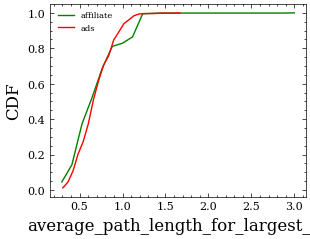

In [33]:
# plt.figure(figsize=(8, 6))
count, bins_negative = np.histogram(df_labeled[df_labeled.label == 'affiliate'].max_degree_centrality, 24)
pdf_negative = count / sum(count)
cdf_negative = np.cumsum(pdf_negative)
plt.plot(bins_negative[1:], cdf_negative, label="affiliate", color='green')

count, bins_positive = np.histogram(df_labeled[df_labeled.label == 'ads'].max_degree_centrality, 24)
pdf_positive = count / sum(count)
cdf_positive = np.cumsum(pdf_positive)
plt.plot(bins_positive[1:], cdf_positive, label="ads", color='red')
plt.legend()
plt.xlabel("average_path_length_for_largest_cc")
plt.ylabel("CDF")
plt.savefig("/home/data/chensun/affi_project/purl/output/results/01_24/std_dev_closeness_centrality.pdf", dpi=300, bbox_inches='tight')

In [35]:
df_labeled[df_labeled.label == 'ads'].max_degree_centrality.describe()

count    490.000000
mean       0.679662
std        0.211800
min        0.245714
25%        0.517130
50%        0.652618
75%        0.826714
max        1.666667
Name: max_degree_centrality, dtype: float64

FileNotFoundError: [Errno 2] No such file or directory: '/home/data/chensun/affi_project/purl/output/results/aff_ads_mean_phaseA/avg_clustering_coefficient.pdf'

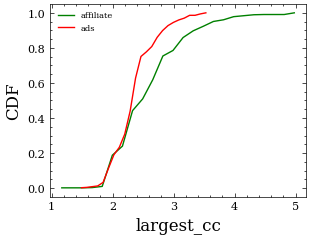

In [29]:
# plt.figure(figsize=(8, 6))
count, bins_negative = np.histogram(df_labeled[df_labeled.label == 'affiliate'].max_avg_path_length, 24)
pdf_negative = count / sum(count)
cdf_negative = np.cumsum(pdf_negative)
plt.plot(bins_negative[1:], cdf_negative, label="affiliate", color='green')

count, bins_positive = np.histogram(df_labeled[df_labeled.label == 'ads'].max_avg_path_length, 24)
pdf_positive = count / sum(count)
cdf_positive = np.cumsum(pdf_positive)
plt.plot(bins_positive[1:], cdf_positive, label="ads", color='red')
plt.legend()
plt.xlabel("largest_cc")
plt.ylabel("CDF")
plt.savefig("/home/data/chensun/affi_project/purl/output/results/aff_ads_mean_phaseA/avg_clustering_coefficient.pdf", dpi=300, bbox_inches='tight')

In [31]:
df_labeled[df_labeled.label == 'ads'].max_avg_path_length.describe()

count    494.000000
mean       2.345440
std        0.347962
min        1.400000
25%        2.140351
50%        2.328609
75%        2.458257
max        3.529370
Name: max_avg_path_length, dtype: float64

/tmp/ipykernel_100071/767929108.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count, bins_negative = np.histogram(df_labeled[df_labeled.counts_decoration < 60][df_labeled.label == 'affiliate'].counts_decoration, 24)
/tmp/ipykernel_100071/767929108.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count, bins_positive = np.histogram(df_labeled[df_labeled.counts_decoration < 60][df_labeled.label == 'ads'].counts_decoration, 24)


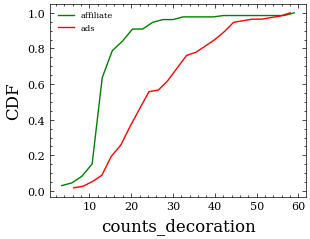

In [39]:
# plt.figure(figsize=(8, 6))
count, bins_negative = np.histogram(df_labeled[df_labeled.counts_decoration < 60][df_labeled.label == 'affiliate'].counts_decoration, 24)
pdf_negative = count / sum(count)
cdf_negative = np.cumsum(pdf_negative)
plt.plot(bins_negative[1:], cdf_negative, label="affiliate", color='green')

count, bins_positive = np.histogram(df_labeled[df_labeled.counts_decoration < 60][df_labeled.label == 'ads'].counts_decoration, 24)
pdf_positive = count / sum(count)
cdf_positive = np.cumsum(pdf_positive)
plt.plot(bins_positive[1:], cdf_positive, label="ads", color='red')
plt.legend()
plt.xlabel("counts_decoration")
plt.ylabel("CDF")
plt.savefig("/home/data/chensun/affi_project/purl/output/results/aff_ads_mean_phaseA/counts_decoration.pdf", dpi=300, bbox_inches='tight')

In [42]:
df_labeled[df_labeled.label == 'ads'].ascendant_has_ad_keyword.describe()

count    114.000000
mean       0.898288
std        0.149537
min        0.230769
25%        0.810847
50%        1.000000
75%        1.000000
max        1.000000
Name: ascendant_has_ad_keyword, dtype: float64

/tmp/ipykernel_100071/1007004516.py:3: RuntimeWarning: divide by zero encountered in divide
  pdf_negative = count / sum(count)
/tmp/ipykernel_100071/1007004516.py:3: RuntimeWarning: invalid value encountered in divide
  pdf_negative = count / sum(count)


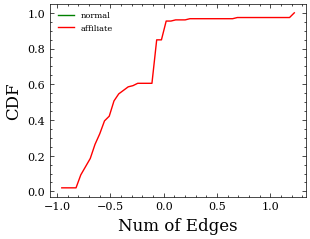

In [43]:
# plt.figure(figsize=(8, 6))
count, bins_negative = np.histogram(df_labeled[df_labeled.label == 'normal'].max_depth_decoration, 50)
pdf_negative = count / sum(count)
cdf_negative = np.cumsum(pdf_negative)
plt.plot(bins_negative[1:], cdf_negative, label="normal", color='green')

count, bins_positive = np.histogram(df_labeled[df_labeled.label == 'affiliate'].max_depth_decoration, 50)
pdf_positive = count / sum(count)
cdf_positive = np.cumsum(pdf_positive)
plt.plot(bins_positive[1:], cdf_positive, label="affiliate", color='red')
plt.legend()
plt.xlabel("Num of Edges")
plt.ylabel("CDF")
plt.savefig("/home/data/chensun/affi_project/purl/output/results/aff_normal_mean_phaseA/max_depth_decoration.pdf", dpi=300, bbox_inches='tight')

In [44]:
count, bins_negative = np.histogram(df_labeled[df_labeled.label == 'Negative'].shannon_entropy, 50)
pdf_negative = count / sum(count)
cdf_negative = np.cumsum(pdf_negative)

/tmp/ipykernel_100071/346222907.py:2: RuntimeWarning: divide by zero encountered in divide
  pdf_negative = count / sum(count)
/tmp/ipykernel_100071/346222907.py:2: RuntimeWarning: invalid value encountered in divide
  pdf_negative = count / sum(count)


In [45]:
cdf_negative[24]

nan

In [46]:
cdf_positive[24]

0.9605263157894738

In [47]:
bins_negative[24]

0.48

/tmp/ipykernel_100071/4016665578.py:3: RuntimeWarning: divide by zero encountered in divide
  pdf = count / sum(count)
/tmp/ipykernel_100071/4016665578.py:3: RuntimeWarning: invalid value encountered in divide
  pdf = count / sum(count)


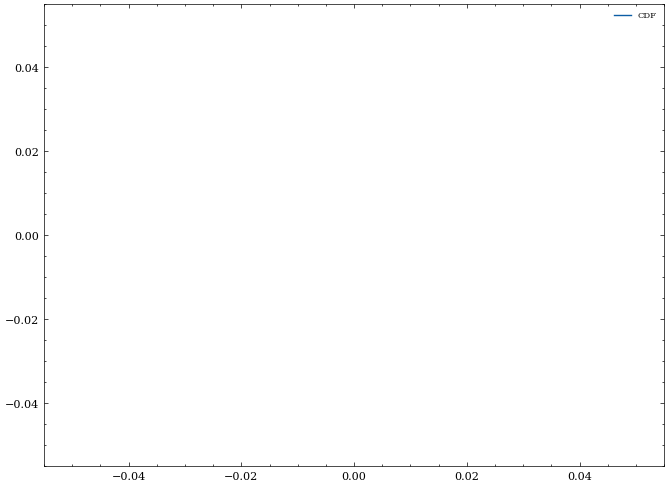

In [48]:
plt.figure(figsize=(8, 6))
count, bins = np.histogram(df_labeled[df_labeled.label == 'Negative'].shannon_entropy, 50)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins[1:], cdf, label="CDF")
plt.legend()
plt.show()

In [49]:
df_labeled[df_labeled.label == 'Positive'].shannon_entropy.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: shannon_entropy, dtype: float64

In [50]:
df_labeled[df_labeled.label == 'Negative'].shannon_entropy.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: shannon_entropy, dtype: float64

In [58]:
df_labeled[df_labeled.label == 'ads'].num_nodes.describe()

count    114.000000
mean      45.729378
std      105.154970
min        5.000000
25%       14.703571
50%       18.102679
75%       27.176692
max      778.744186
Name: num_nodes, dtype: float64

/tmp/ipykernel_100071/2252857499.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count, bins_negative = np.histogram(df_labeled[df_labeled.num_nodes < 100][df_labeled.label == 'affiliate'].num_nodes, 50)
/tmp/ipykernel_100071/2252857499.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count, bins_positive = np.histogram(df_labeled[df_labeled.num_nodes < 100][df_labeled.label == 'ads'].num_nodes, 50)


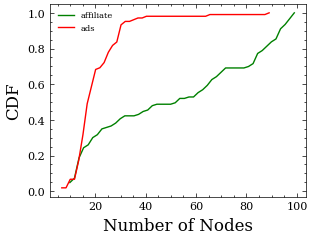

In [59]:
# plt.figure(figsize=(8, 6))
count, bins_negative = np.histogram(df_labeled[df_labeled.num_nodes < 100][df_labeled.label == 'affiliate'].num_nodes, 50)
pdf_negative = count / sum(count)
cdf_negative = np.cumsum(pdf_negative)
plt.plot(bins_negative[1:], cdf_negative, label="affiliate", color='green')

count, bins_positive = np.histogram(df_labeled[df_labeled.num_nodes < 100][df_labeled.label == 'ads'].num_nodes, 50)
pdf_positive = count / sum(count)
cdf_positive = np.cumsum(pdf_positive)
plt.plot(bins_positive[1:], cdf_positive, label="ads", color='red')
plt.legend()
plt.xlabel("Number of Nodes")
plt.ylabel("CDF")
plt.savefig("/home/data/chensun/affi_project/purl/output/results/aff_normal_mean_phaseA/number_of_nodes_cdf.pdf", dpi=300, bbox_inches='tight')

In [54]:
cdf_negative[6]

nan

In [55]:
cdf_positive[6]

0.3170731707317073

In [56]:
bins_negative[6]

0.12